In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

In [2]:
import os
import warnings

warnings.filterwarnings("ignore") 

In [4]:
from darts import TimeSeries
from darts.dataprocessing.pipeline import Pipeline
from darts.models import TFTModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import StaticCovariatesTransformer, MissingValuesFiller

In [5]:
TIME_COL = "Date"
TARGET = "Weekly_Sales"
STATIC_COV = ["Store", "Dept", "Type", "Size"]
DYNAMIC_COV_FILL_0 = ["IsHoliday", 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
DYNAMIC_COV_FILL_INTERPOLATE = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
FREQ = "W-FRI"
FORECAST_HORIZON = 16 # weeks
SCALER = Scaler()
TRANSFORMER = StaticCovariatesTransformer()
PIPELINE = Pipeline([SCALER, TRANSFORMER])

In [6]:
df = pd.read_csv('data/train.csv')
store_info = pd.read_csv('data/stores.csv')
exo_feat = pd.read_csv('data/features.csv').drop(columns='IsHoliday')

In [7]:
# join all data frames
df = pd.merge(df, store_info, on=['Store'], how='left')
df = pd.merge(df, exo_feat, on=['Store', TIME_COL], how='left')

In [8]:
df[TIME_COL] = pd.to_datetime(df[TIME_COL])
df[TARGET] = np.where(df[TARGET] < 0, 0, df[TARGET]) # remove negative values
df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']] = df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']].fillna(0) # fill missing values with nan
df["IsHoliday"] = df["IsHoliday"]*1 # convert boolean into binary
df["Size"] = np.where(df["Size"] < store_info["Size"].quantile(0.25), "small",
                np.where(df["Size"] > store_info["Size"].quantile(0.75), "large",
"medium")) # make size a categorical variable

In [9]:
store_selecionada = 2 
dept_selecionada= 1

# Filtrar o DataFrame para manter apenas os dados dessa loja
df = df[df['Store'] == store_selecionada]
df=df[df['Dept'] == dept_selecionada]

In [10]:
# 16 weeks to for test
train = df[df[TIME_COL] <= (max(df[TIME_COL])-timedelta(weeks=FORECAST_HORIZON))]
test = df[df[TIME_COL] > (max(df[TIME_COL])-timedelta(weeks=FORECAST_HORIZON))]

In [11]:
# read train and test datasets and transform train dataset
train_darts = TimeSeries.from_group_dataframe(
df=train,
group_cols=STATIC_COV,
time_col=TIME_COL,
value_cols=TARGET,
freq=FREQ, 
fill_missing_dates=True,
fillna_value=0)

In [12]:
# create dynamic covariates for each serie in the training darts
dynamic_covariates = []
for serie in train_darts:
    # add the month and week as a covariate
    covariate = datetime_attribute_timeseries(
        serie,
        attribute="month",
        one_hot=True,
        cyclic=False,
        add_length=FORECAST_HORIZON,
    )
    covariate = covariate.stack(
        datetime_attribute_timeseries(
            serie,
            attribute="week",
            one_hot=True,
            cyclic=False,
            add_length=FORECAST_HORIZON,
        )
    )


    dynamic_covariates.append(covariate)


In [13]:
# scale covariates
dynamic_covariates_transformed = SCALER.fit_transform(dynamic_covariates)

# scale data and transform static covariates
data_transformed = PIPELINE.fit_transform(train_darts)

In [14]:
TFT_params = {
    "input_chunk_length": 52, # number of weeks to lookback
    "output_chunk_length": FORECAST_HORIZON,
    "hidden_size": 2,
    "lstm_layers": 8,
    "num_attention_heads": 1,
    "dropout": 0.2,
    "batch_size":32,
    "n_epochs": 20,
    "likelihood": QuantileRegression(quantiles=[0.25, 0.5, 0.75]),
    "random_state": 42,
    "use_static_covariates": False,
    "optimizer_kwargs": {"lr": 1e-3},}
tft_model = TFTModel(**TFT_params)
tft_model.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)
pred = PIPELINE.inverse_transform(tft_model.predict(n=FORECAST_HORIZON, series=data_transformed, num_samples=50, future_covariates=dynamic_covariates_transformed))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

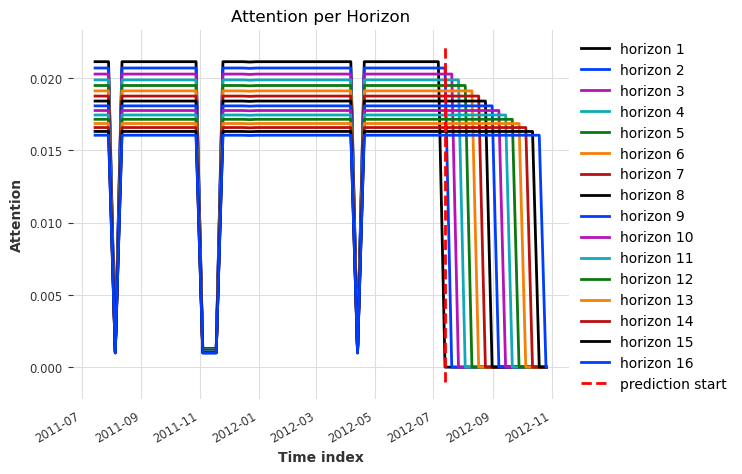

<AxesSubplot:title={'center':'Attention per Horizon'}, xlabel='Time index', ylabel='Attention'>

In [15]:
from darts.explainability import TFTExplainer

explainer = TFTExplainer(
tft_model,
background_series=data_transformed[0],
background_future_covariates=dynamic_covariates_transformed[0],
)
explainability_result = explainer.explain()

explainer.plot_attention(explainability_result, plot_type="all", show_index_as='time')

In [16]:
test_darts = TimeSeries.from_group_dataframe(
df=test,
group_cols=STATIC_COV,
time_col=TIME_COL,
value_cols=TARGET,
freq=FREQ, 
fill_missing_dates=True,
fillna_value=0)


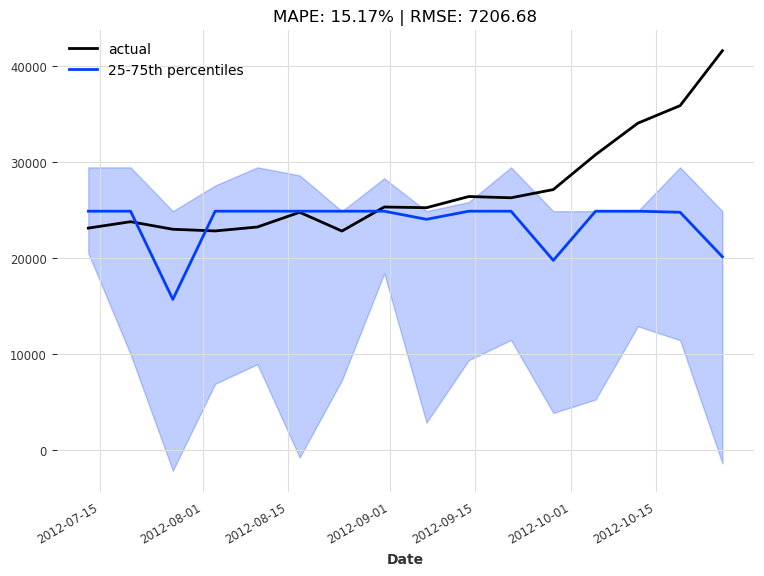

In [17]:
from darts.metrics import mape, rmse

def eval_model(val_series, pred_series):
    # plot actual series
    plt.figure(figsize=(9, 6))
    val_series[: pred_series.end_time()].plot(label="actual")
    # plot prediction with quantile ranges
    pred_series.plot(
    low_quantile=0.25, high_quantile=0.75, label=f"{int(0.25 * 100)}-{int(0.75 * 100)}th percentiles"
    )
    plt.title(f"MAPE: {round(mape(val_series, pred_series),2)}% | RMSE: {round(rmse(val_series, pred_series),2)}")
    plt.legend()
    
eval_model(test_darts[0], pred[0])

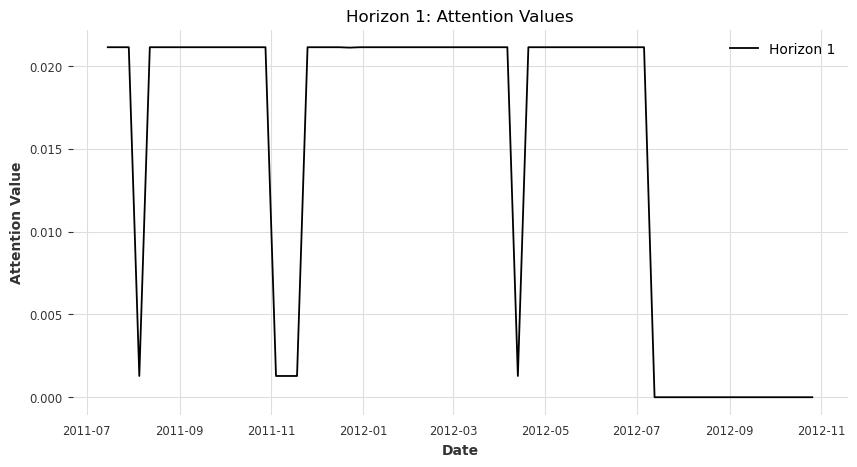

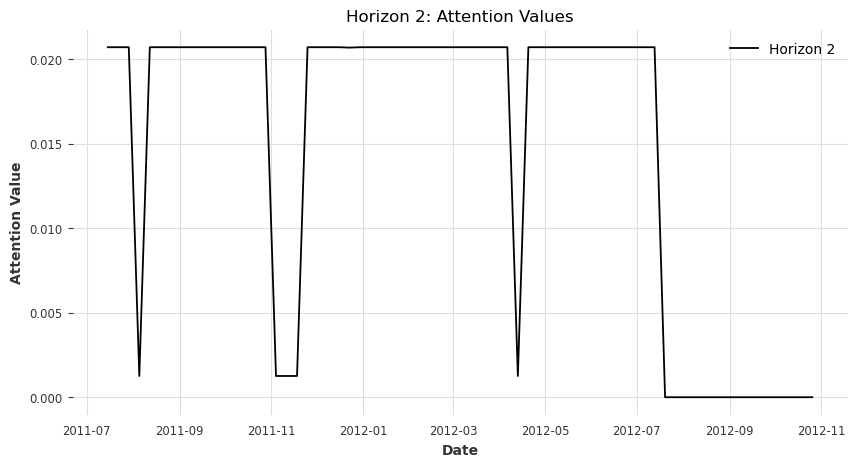

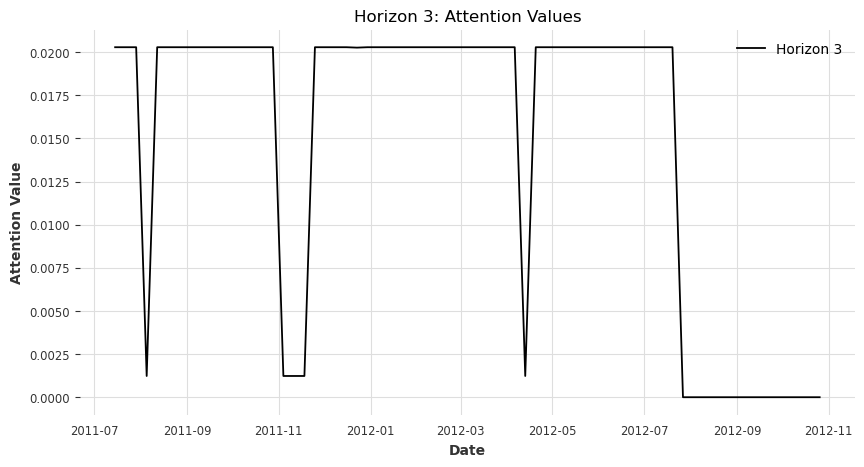

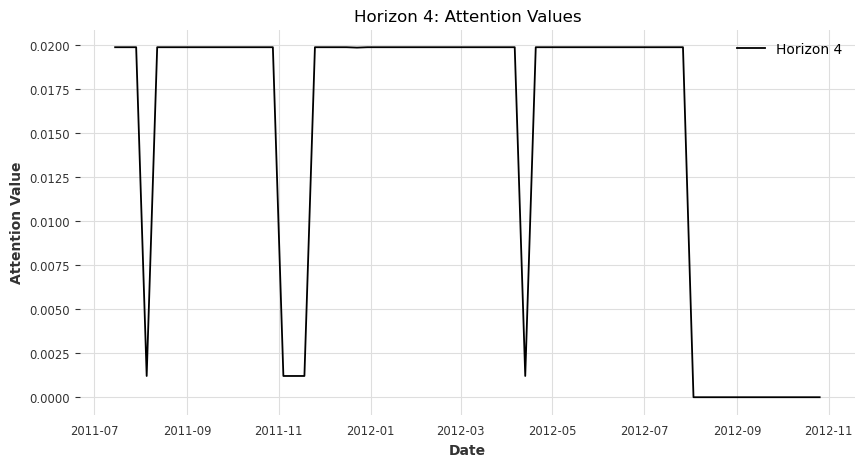

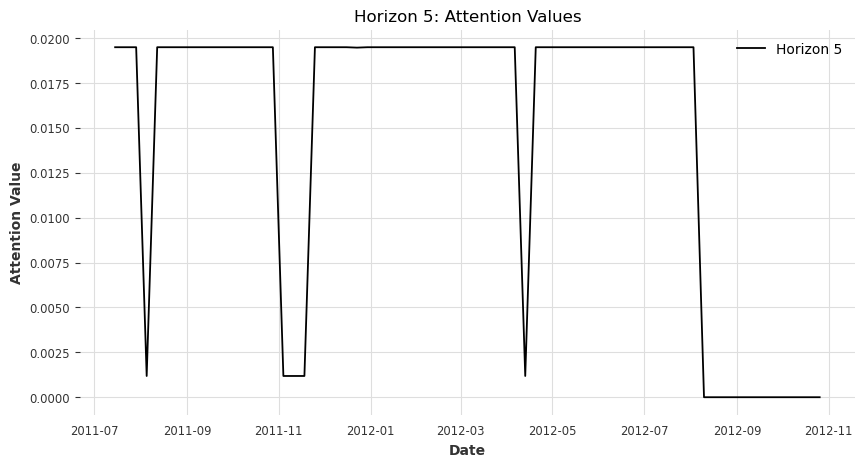

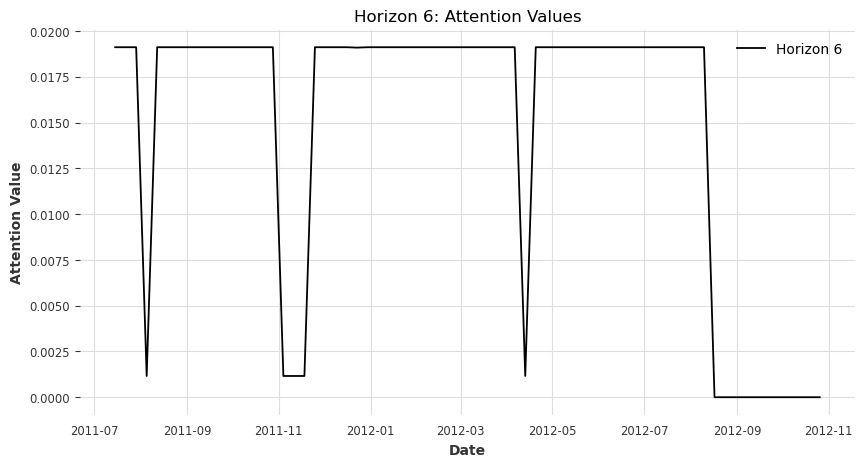

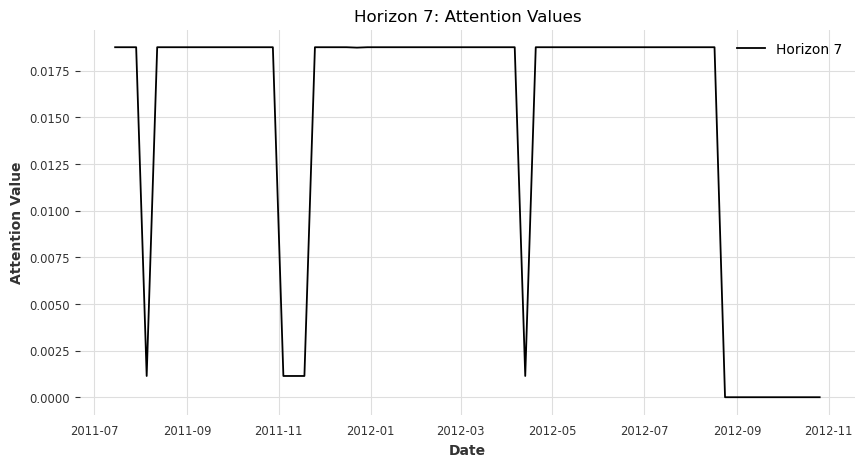

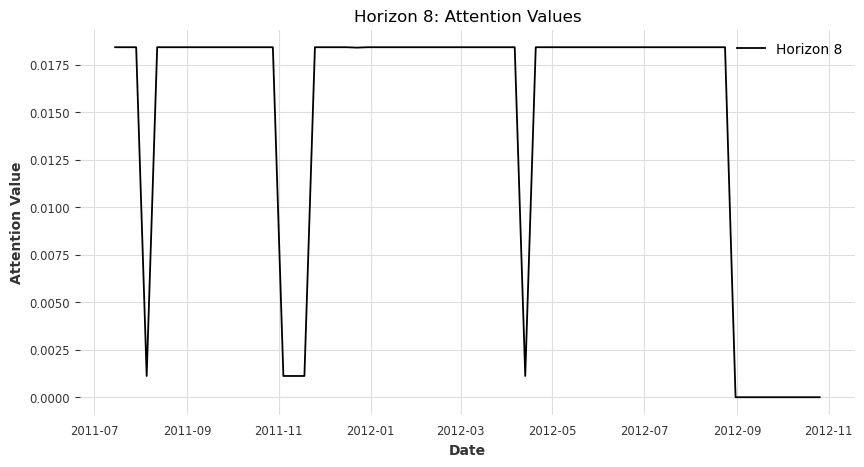

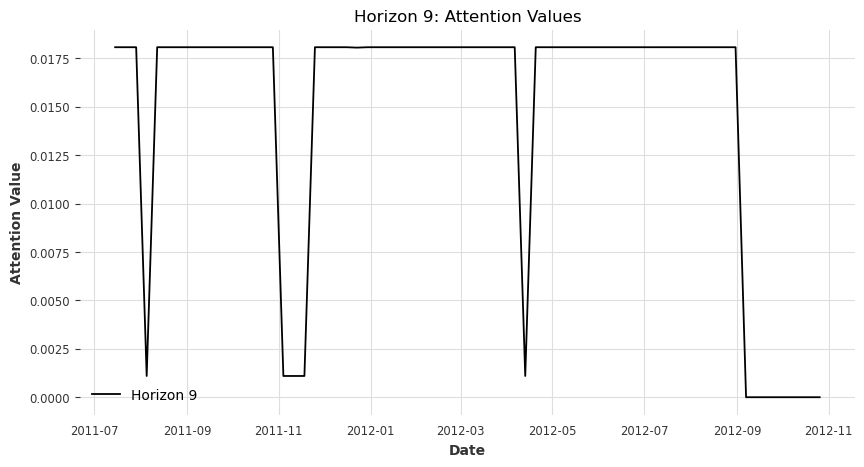

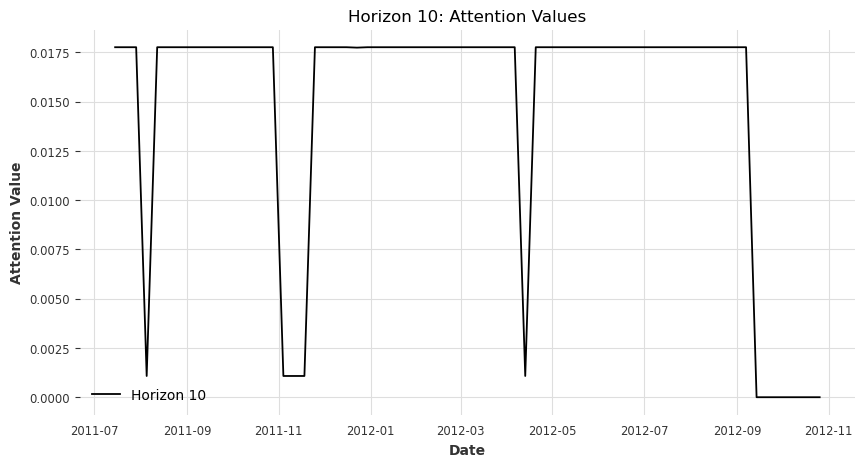

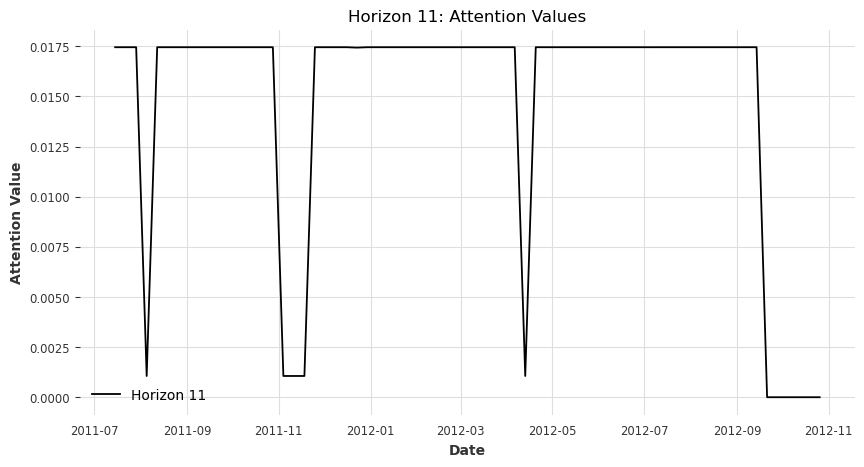

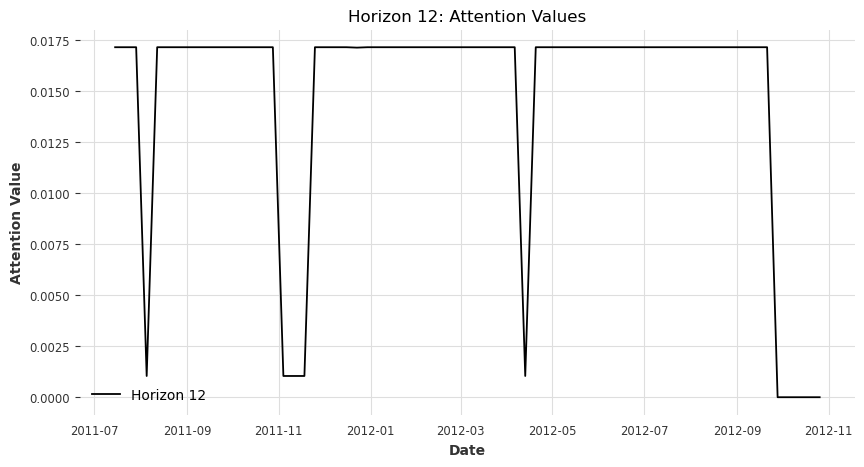

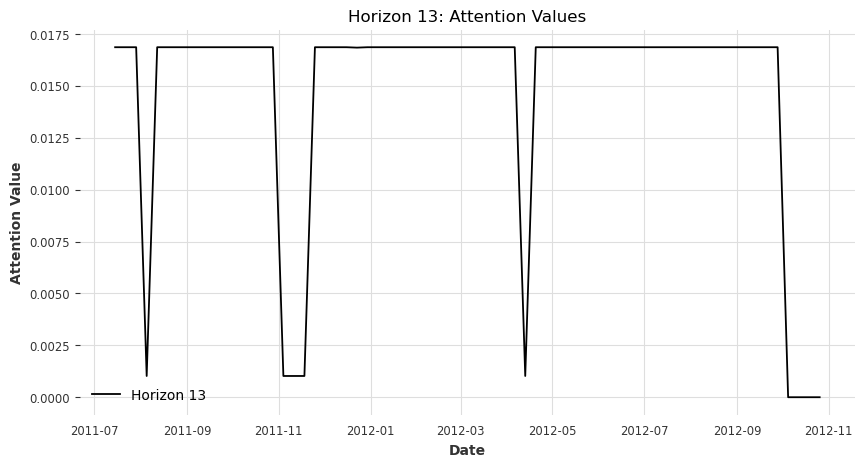

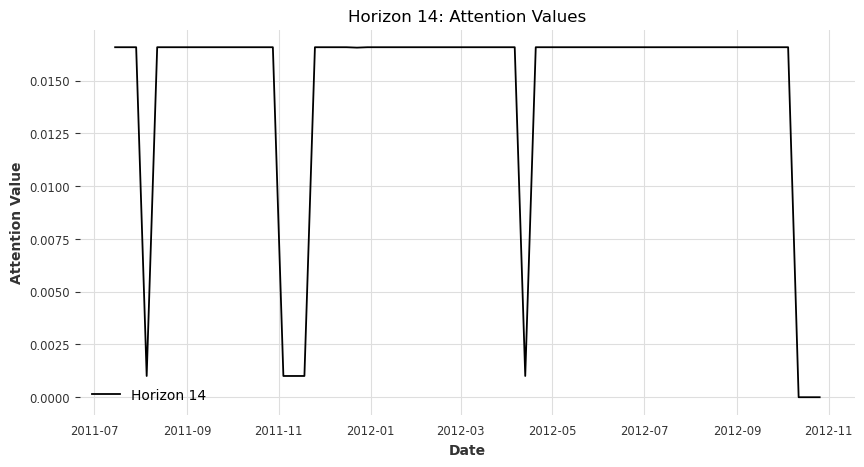

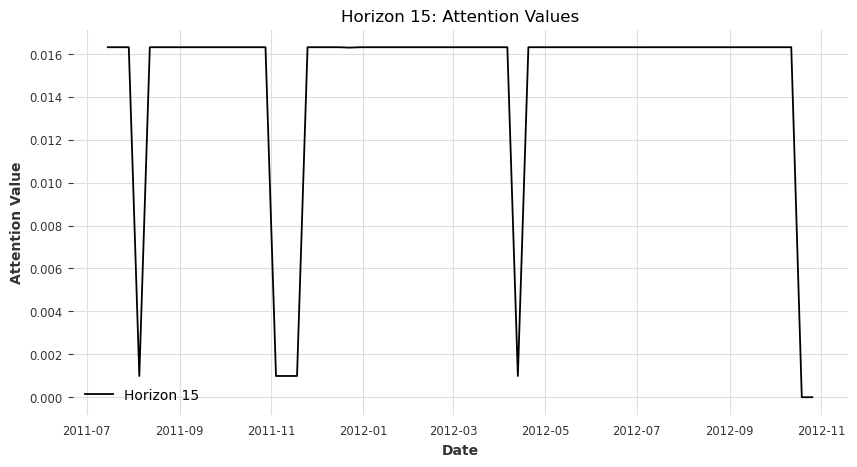

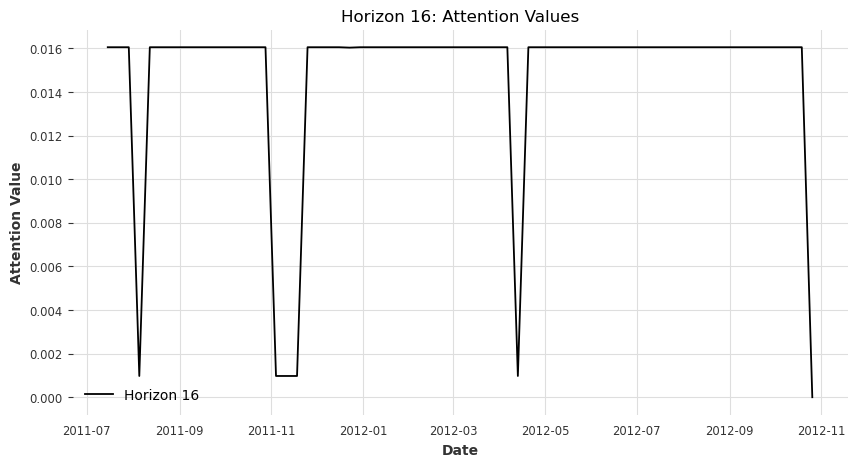

In [19]:
import matplotlib.pyplot as plt

attention_values = explainability_result.get_attention()

for component in range(16):
    attention_component_values = attention_values.univariate_component(component).values()
    dates = attention_values.univariate_component(component).time_index 
    
    plt.figure(figsize=(10, 5))
    plt.plot(dates, attention_component_values, label=f'Horizon {component+1}')
    plt.xlabel('Date')
    plt.ylabel('Attention Value')
    plt.title(f'Horizon {component+1}: Attention Values')
    plt.legend()
    plt.show()


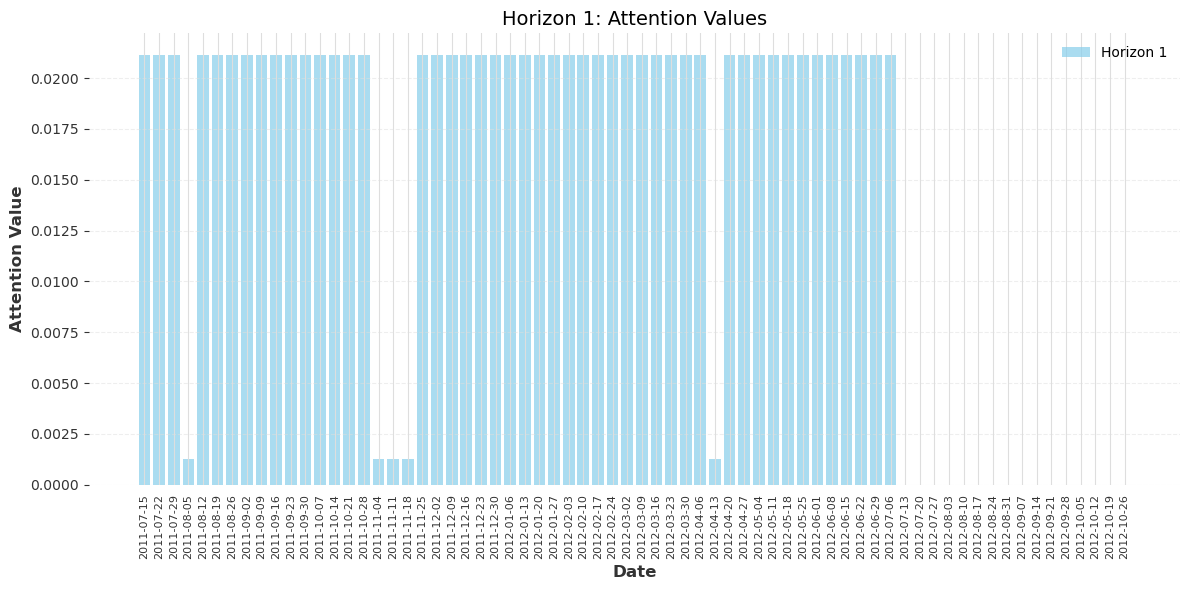

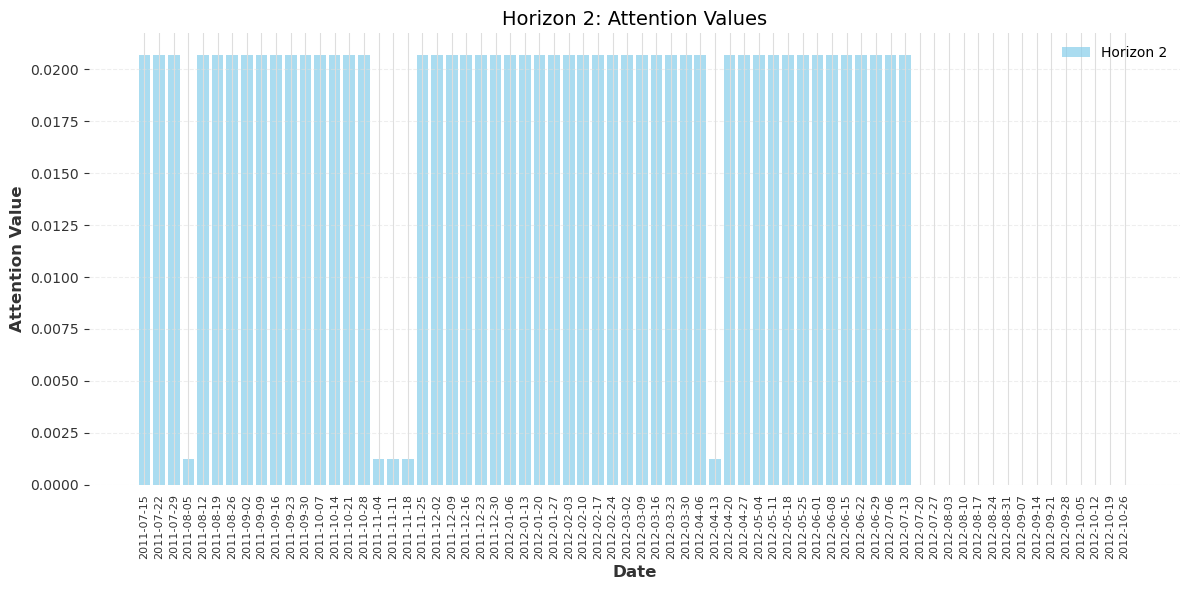

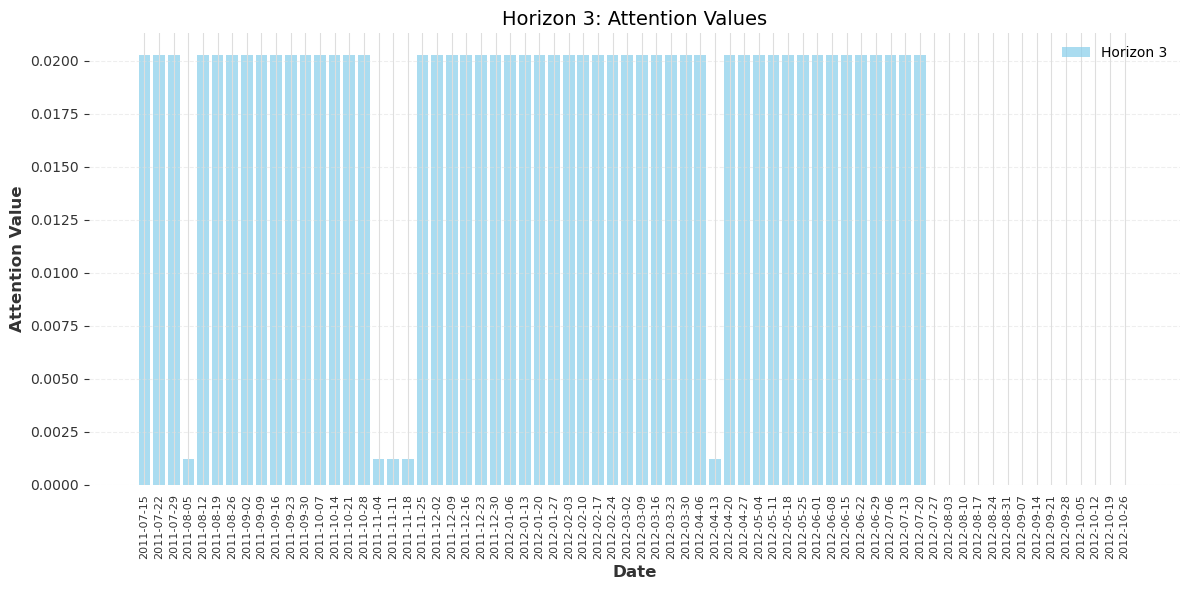

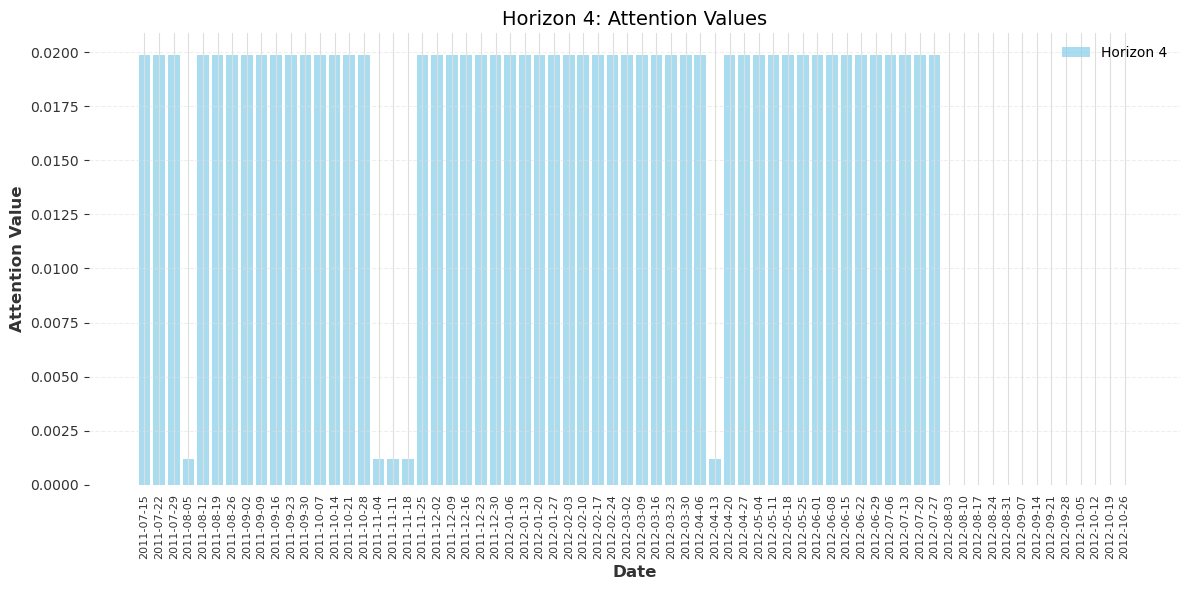

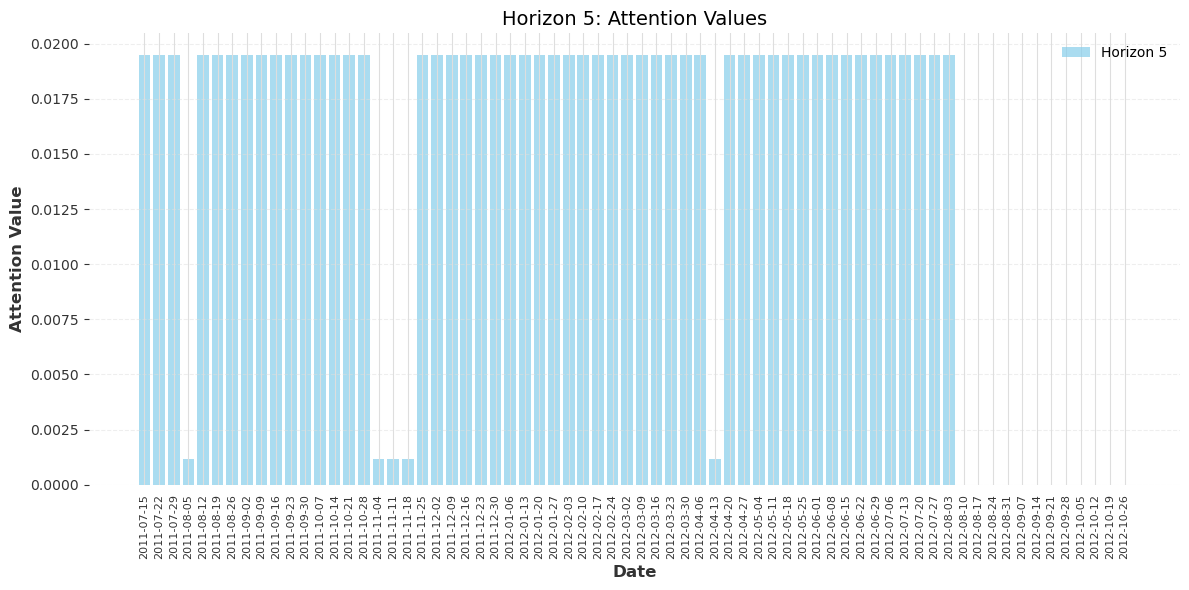

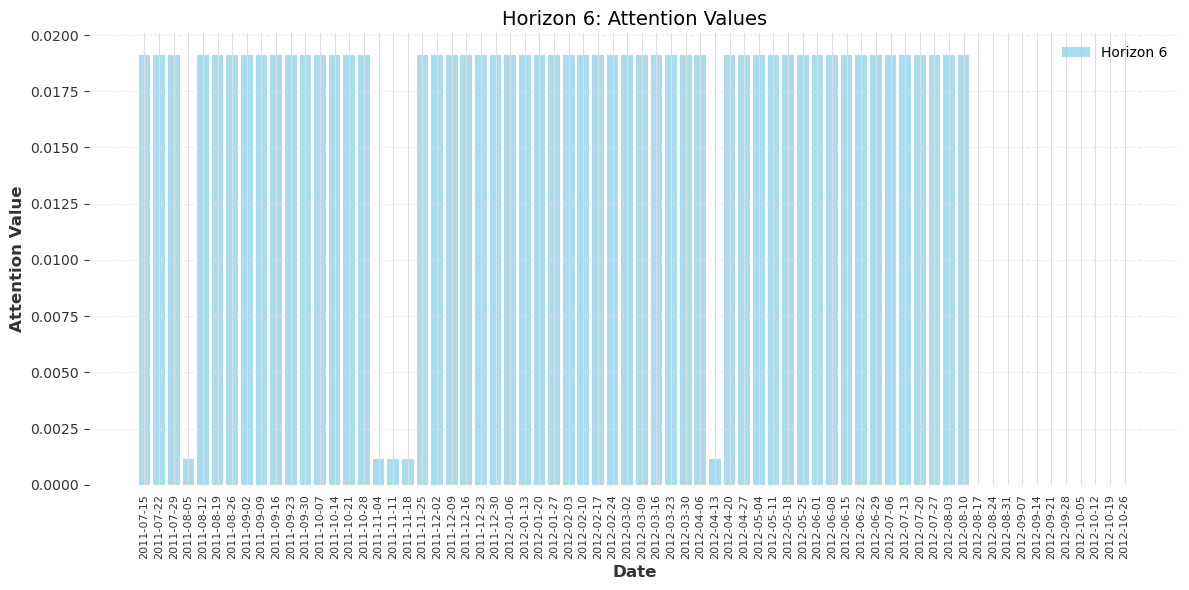

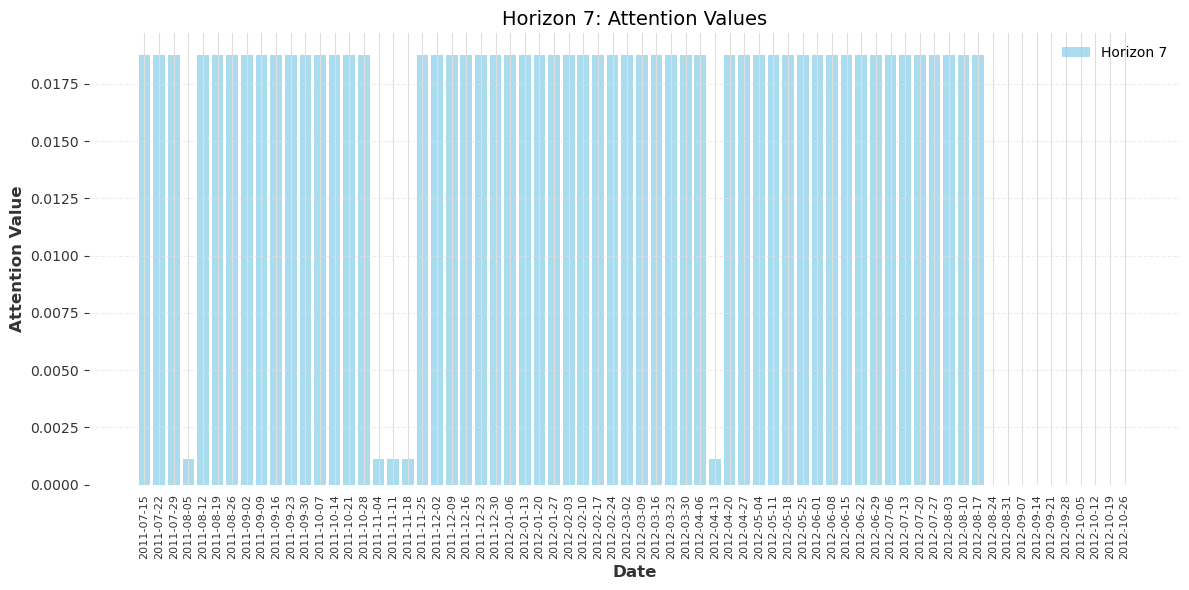

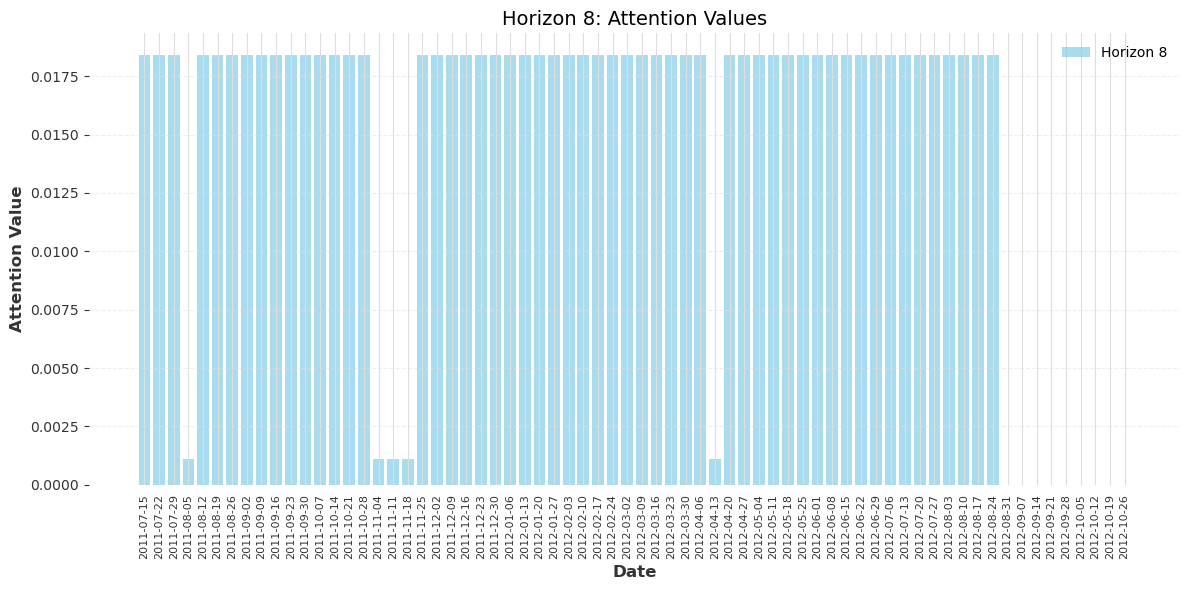

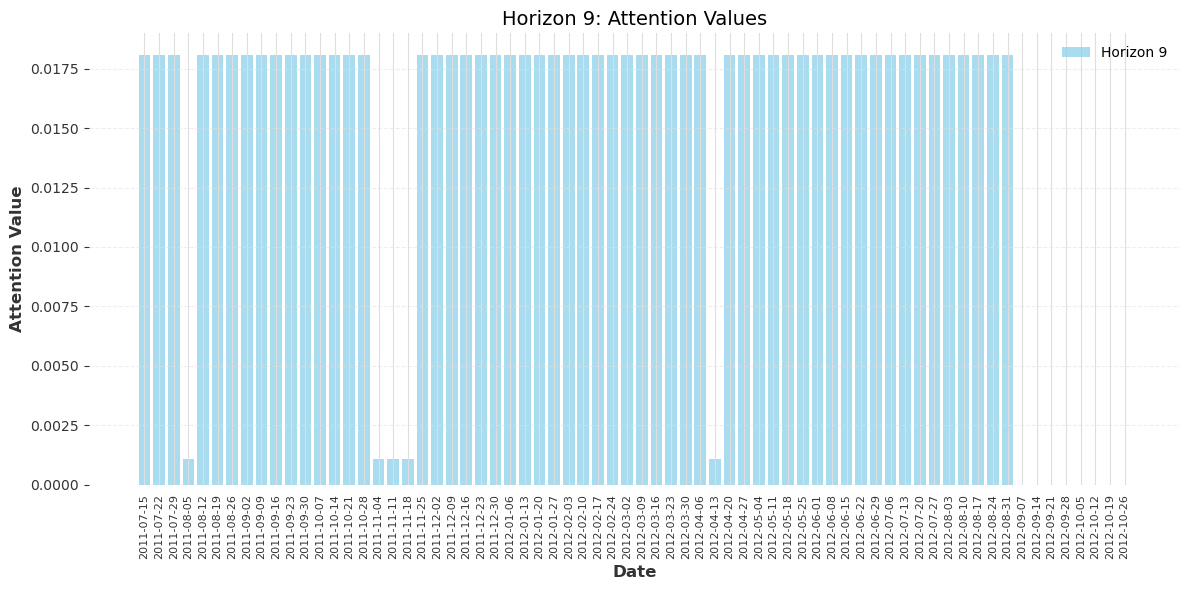

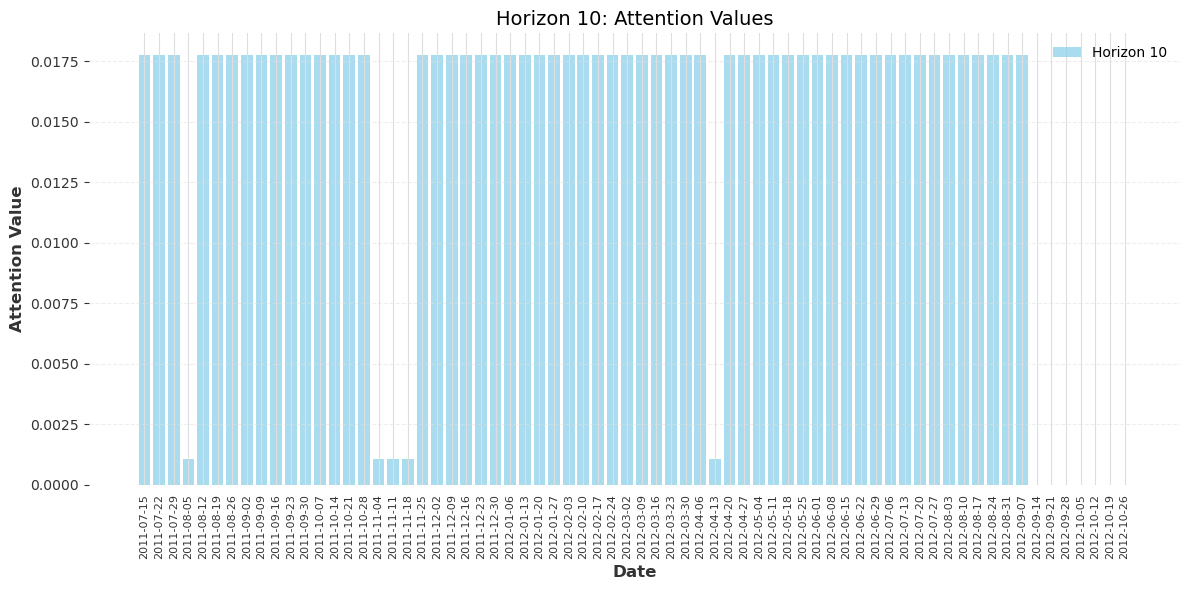

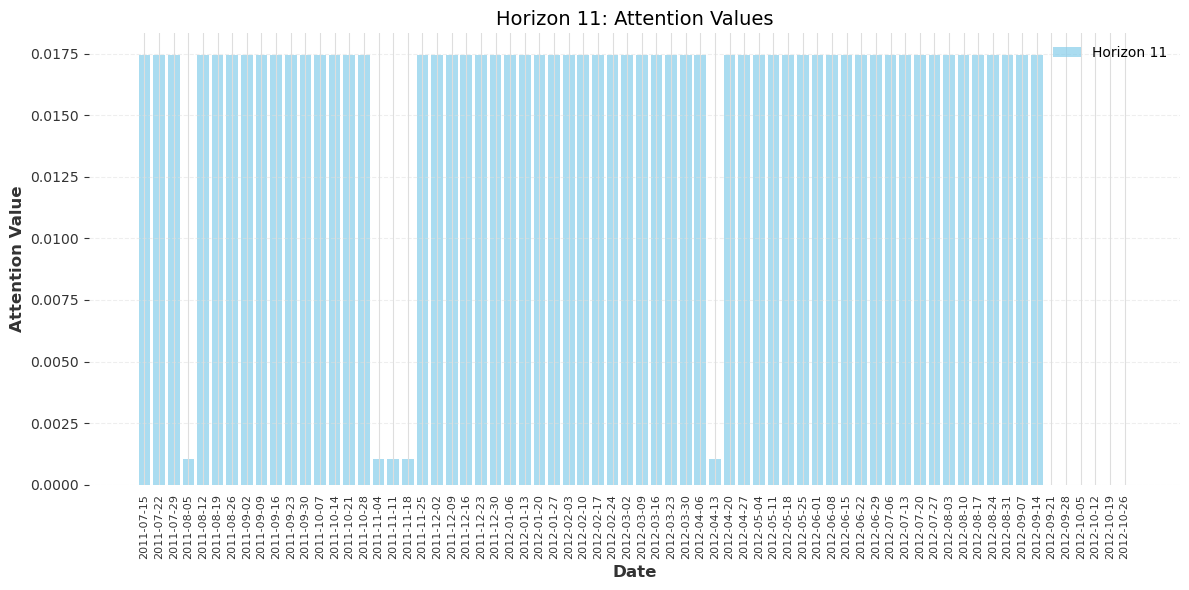

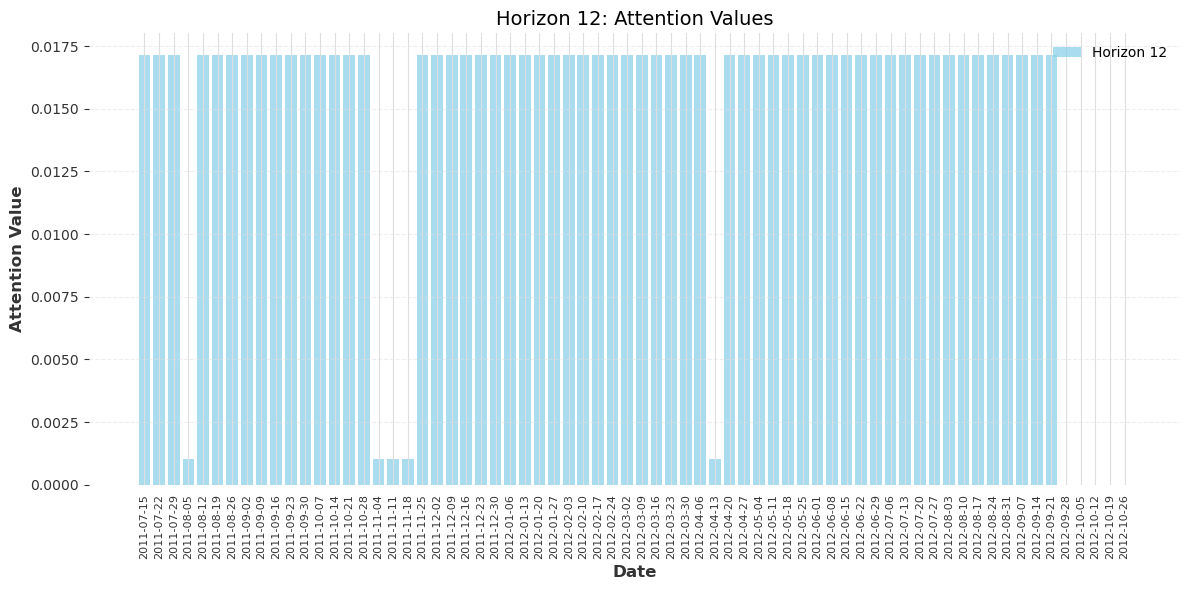

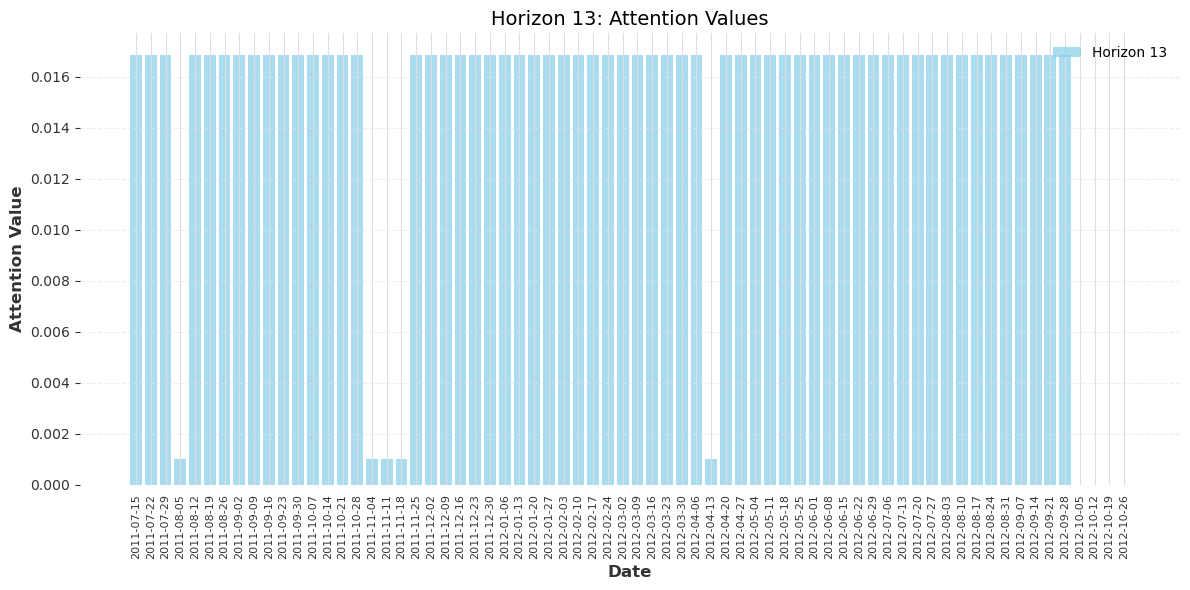

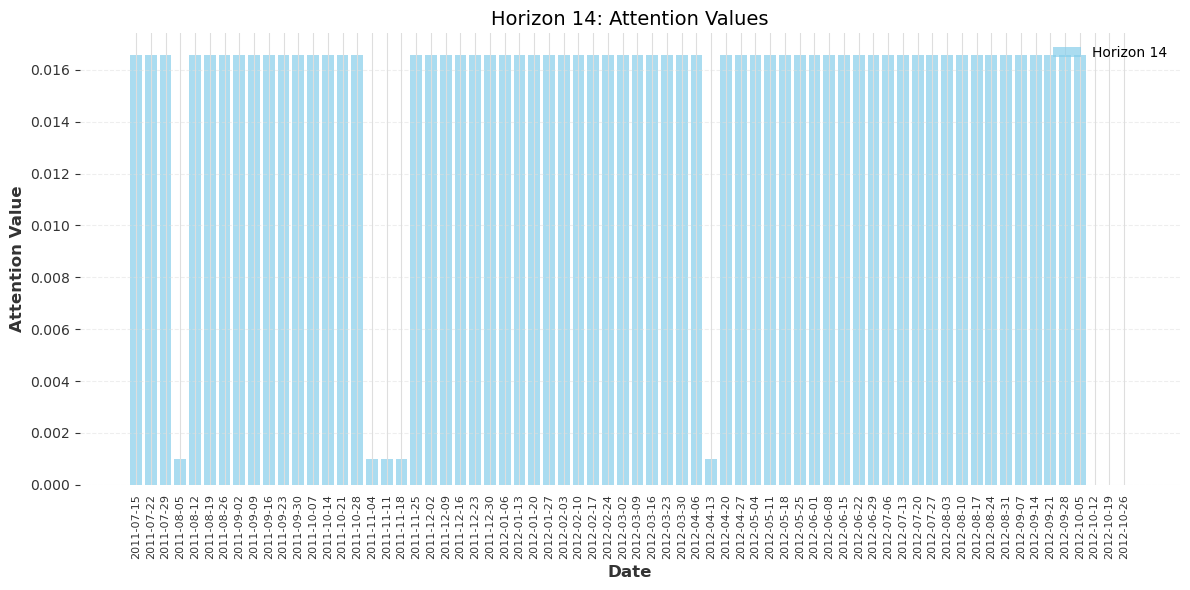

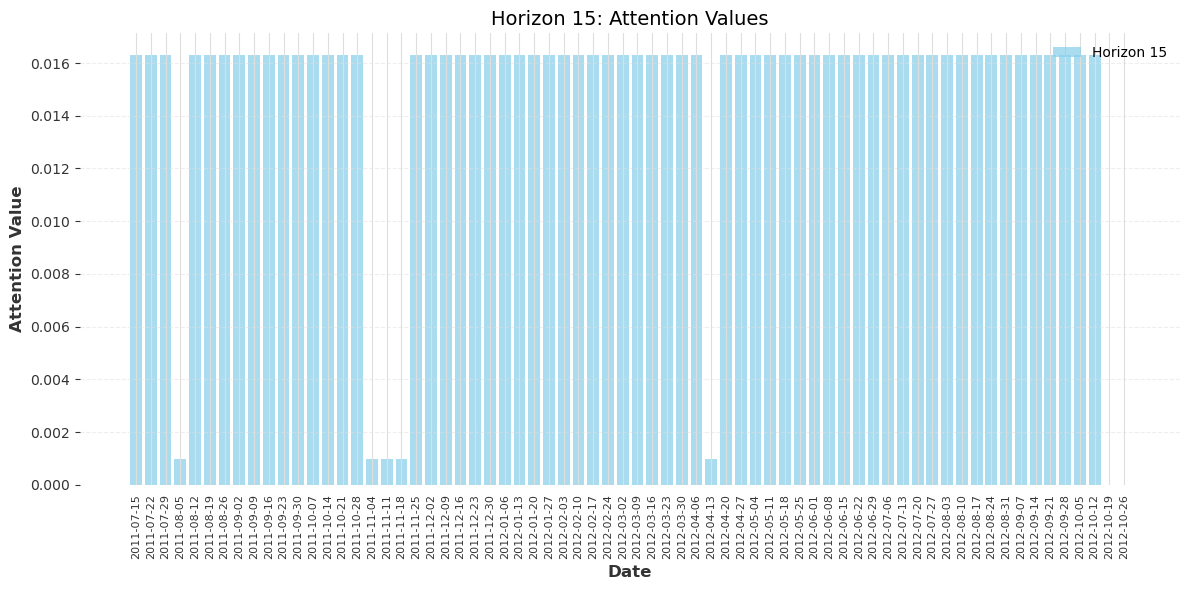

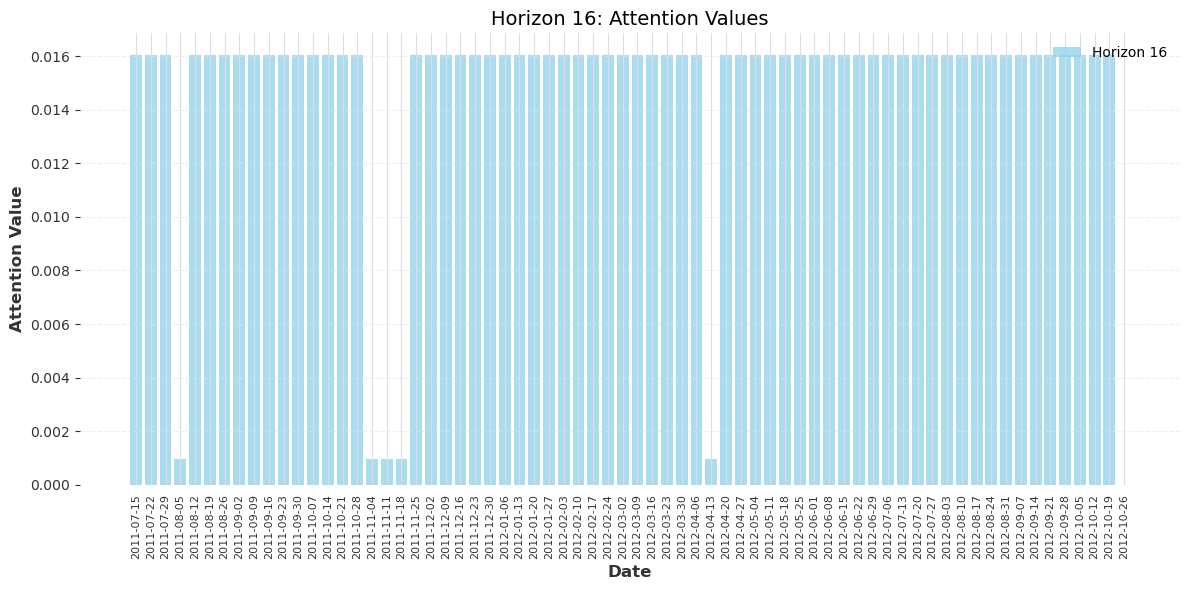

In [20]:
import matplotlib.pyplot as plt

for component in range(16):
    # Accessing the attention values for the current component
    attention_component_values = [value[0] for value in attention_values.univariate_component(component).values()]
    dates = attention_values.univariate_component(component).time_index  # Getting the corresponding dates
    
    # Converting dates to formatted strings
    formatted_dates = [date.strftime('%Y-%m-%d') for date in dates]
    
    # Creating a bar plot for the current component
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(formatted_dates)), attention_component_values, align='center', label=f'Horizon {component+1}', color='skyblue', alpha=0.7)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Attention Value', fontsize=12)
    plt.title(f'Horizon {component+1}: Attention Values', fontsize=14)
    plt.xticks(range(len(formatted_dates)), formatted_dates, rotation=90, fontsize=8)  
    plt.yticks(fontsize=10)  
    plt.grid(axis='y', linestyle='--', alpha=0.5)  
    plt.tight_layout()  
    plt.legend(fontsize=10)  
    plt.show()